# Training machine learning model for cellulose solubility in ionic liquids prediction

In [1]:
from tensorflow import keras
import tensorflow as tf
import pandas as pd
import numpy as np
from rdkit import Chem
from rdkit.Chem import AllChem
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import sklearn
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from rdkit.Chem import Descriptors
from sklearn.model_selection import KFold
from sklearn.linear_model import Ridge
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
import shap

2024-05-28 13:03:09.043643: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-05-28 13:03:09.999358: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


## Training models on total dataset

1. Read dataset

In [2]:
df = pd.read_csv('dataset_for_cellulose_solubility_ML_model.csv')
smis = list(df.loc[:, 'smiles'])
cation = list(df.loc[:, 'cation'])
anion = list(df.loc[:, 'anion'])
Ts = list(df.loc[:, 'T'])
Crystal = list(df.loc[:, 'cellulose_crystal'])
Crystal_avicel = []
Crystal_MCC = []
Crystal_cellulose = []
for item in Crystal:
    if item == 'Avicel':
        Crystal_avicel.append(1)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(0)
    
    elif item == 'MCC':
        Crystal_avicel.append(0)
        Crystal_MCC.append(1)
        Crystal_cellulose.append(0)
        
    elif item == 'cellulose':
        Crystal_avicel.append(0)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(1)
        
heating_time = list(df.loc[:,'heating_time'])
Ys = list(df.loc[:, 'solv'])

2. Calculate descriptors

In [3]:
def getMolDescriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    res = []
    for nm, fn in Descriptors._descList:
        res.append(fn(mol))
    return res
def smiles_to_MACCS(smi): 
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.array(fp, float)
    return fp
Des_cation = np.array([getMolDescriptors(c) for c in cation])
Des_anion = np.array([getMolDescriptors(a) for a in anion])
fp_anion = np.array([smiles_to_MACCS(a) for a in anion])
fp_cation = np.array([smiles_to_MACCS(c) for c in cation])
fp_mol = np.array([smiles_to_MACCS(s) for s in smis])
X = np.c_[fp_cation, Des_cation, fp_anion, Des_anion, Ts, heating_time, Crystal_avicel, Crystal_MCC, Crystal_cellulose]
Y = np.array(Ys).reshape(len(Ys), 1)

3. Split traning set and testing set

In [4]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

4. Random forest (RF) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R^2_test=0.664952
mse_test=17.310594


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


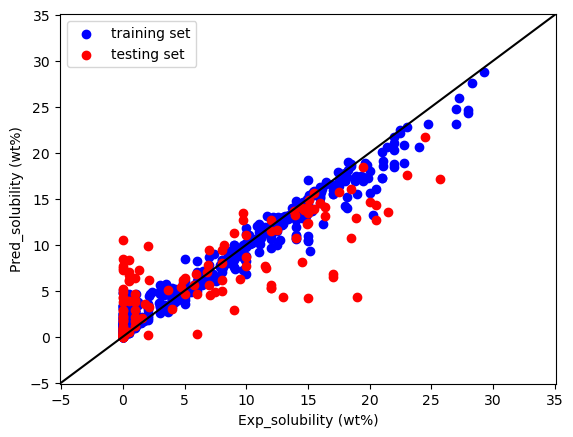

In [5]:
regr = RandomForestRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

5. Extreme gradient boosting (XGBoost) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


R^2_test=0.593381
mse_test=21.008370


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


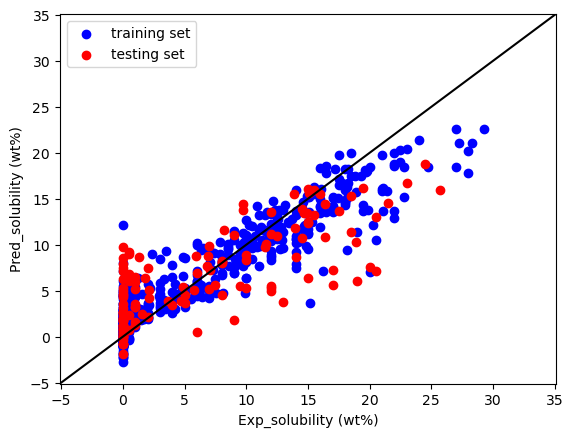

In [6]:
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

6. Ridge regression

R^2_test=0.393287
mse_test=31.346416


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


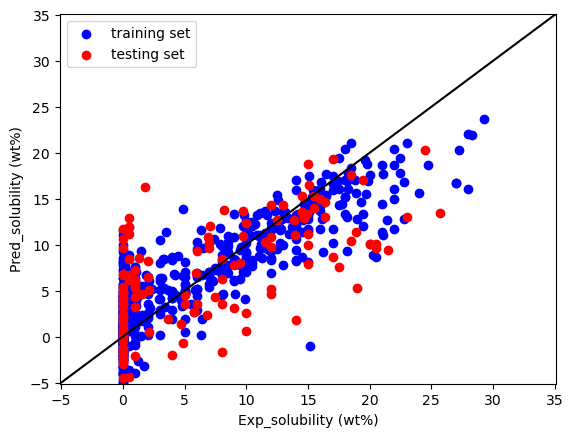

In [7]:
regr = Ridge(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

7. Artificial neural network (ANN) model

In [8]:
keras.utils.set_random_seed(1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=759, input_shape=(None, 759), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=759, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))
model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.0001))
model.fit(X_train, Y_train, epochs=7000)

2024-05-28 13:03:54.528971: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 13:03:54.551238: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 13:03:54.551460: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

Epoch 1/7000


2024-05-28 13:03:54.560474: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 13:03:54.560714: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysfs-bus-pci#L344-L355
2024-05-28 13:03:54.560890: I tensorflow/compiler/xla/stream_executor/cuda/cuda_gpu_executor.cc:995] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero. See more at https://github.com/torvalds/linux/blob/v6.0/Documentation/ABI/testing/sysf

17/17 [==============================] - 2s 2ms/step - loss: 9793224.0000
Epoch 2/7000
17/17 [==============================] - 0s 2ms/step - loss: 29131096.0000
Epoch 3/7000
17/17 [==============================] - 0s 2ms/step - loss: 566691776.0000
Epoch 4/7000
17/17 [==============================] - 0s 2ms/step - loss: 97855392.0000
Epoch 5/7000
17/17 [==============================] - 0s 2ms/step - loss: 452866432.0000
Epoch 6/7000
17/17 [==============================] - 0s 2ms/step - loss: 5128666.0000
Epoch 7/7000
17/17 [==============================] - 0s 2ms/step - loss: 171741056.0000
Epoch 8/7000
17/17 [==============================] - 0s 2ms/step - loss: 494215104.0000
Epoch 9/7000
17/17 [==============================] - 0s 2ms/step - loss: 276074560.0000
Epoch 10/7000
17/17 [==============================] - 0s 2ms/step - loss: 253604256.0000
Epoch 11/7000
17/17 [==============================] - 0s 2ms/step - loss: 818123072.0000
Epoch 12/7000
17/17 [=================

17/17 [==============================] - 0s 844us/step
R^2_test=0.618797
mse_test=19.695219


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


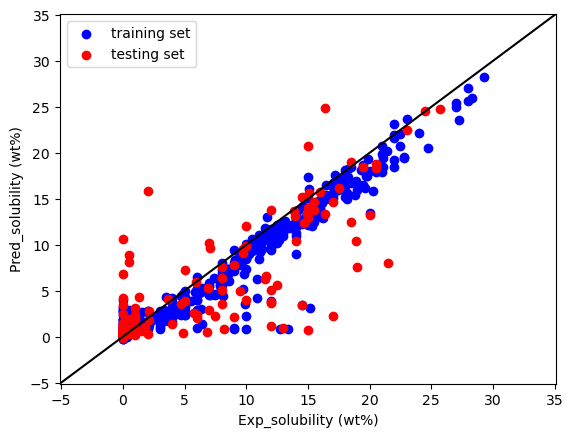

In [9]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

## Training models on data points with water content less than 1%

1. Read dataset

In [10]:
df = pd.read_csv('dataset_for_cellulose_solubility_ML_model_water_content_less_1%.csv')
smis = list(df.loc[:, 'smiles'])
cation = list(df.loc[:, 'cation'])
anion = list(df.loc[:, 'anion'])
Ts = list(df.loc[:, 'T'])
Crystal = list(df.loc[:, 'cellulose_crystal'])
Crystal_avicel = []
Crystal_MCC = []
Crystal_cellulose = []
for item in Crystal:
    if item == 'Avicel':
        Crystal_avicel.append(1)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(0)
    
    elif item == 'MCC':
        Crystal_avicel.append(0)
        Crystal_MCC.append(1)
        Crystal_cellulose.append(0)
        
    elif item == 'cellulose':
        Crystal_avicel.append(0)
        Crystal_MCC.append(0)
        Crystal_cellulose.append(1)
        
heating_time = list(df.loc[:,'heating_time'])
Ys = list(df.loc[:, 'solv'])

2. Calculate descriptors

In [11]:
def getMolDescriptors(smi):
    mol = Chem.MolFromSmiles(smi)
    res = []
    for nm, fn in Descriptors._descList:
        res.append(fn(mol))
    return res
def smiles_to_MACCS(smi): 
    mol = Chem.MolFromSmiles(smi)
    fp = AllChem.GetMACCSKeysFingerprint(mol)
    fp = np.array(fp, float)
    return fp
Des_cation = np.array([getMolDescriptors(c) for c in cation])
Des_anion = np.array([getMolDescriptors(a) for a in anion])
fp_anion = np.array([smiles_to_MACCS(a) for a in anion])
fp_cation = np.array([smiles_to_MACCS(c) for c in cation])
fp_mol = np.array([smiles_to_MACCS(s) for s in smis])
X = np.c_[fp_cation, Des_cation, fp_anion, Des_anion, Ts, heating_time, Crystal_avicel, Crystal_MCC, Crystal_cellulose]
Y = np.array(Ys).reshape(len(Ys), 1)

3. Split traning set and testing set

In [12]:
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=1)

4. Random forest (RF) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().


R^2_test=0.863771
mse_test=9.014726


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


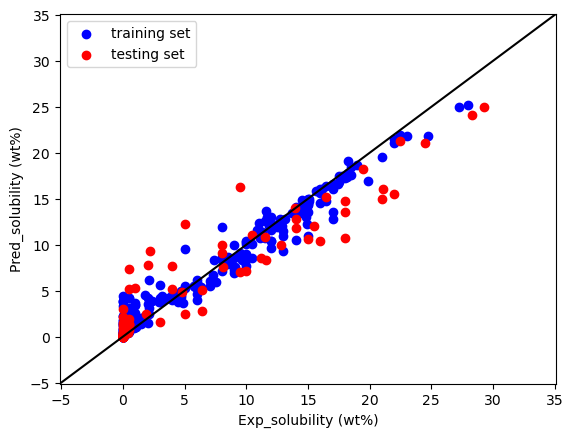

In [13]:
regr = RandomForestRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

5. Extreme gradient boosting (XGBoost) regression

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().


R^2_test=0.850821
mse_test=9.871671


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


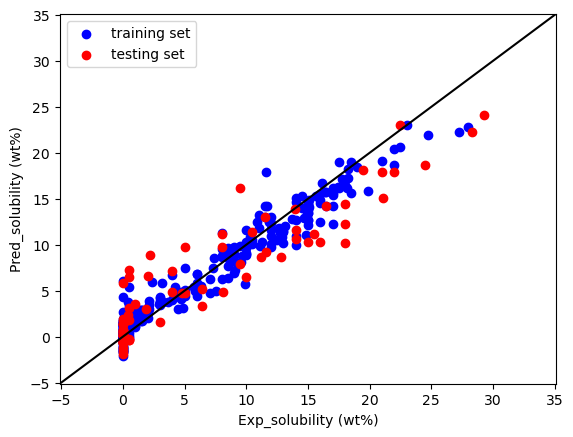

In [14]:
regr = GradientBoostingRegressor(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

6. Ridge regression

R^2_test=0.664458
mse_test=22.203920


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


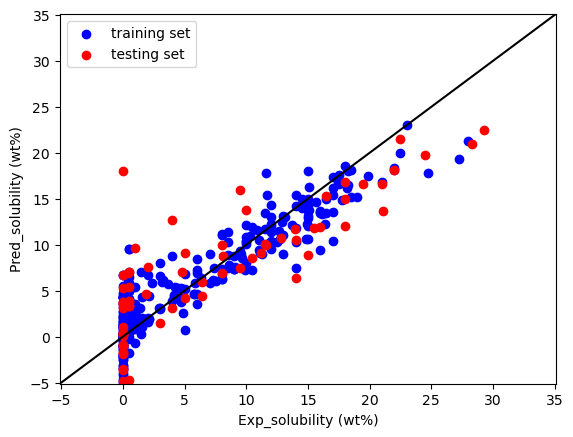

In [15]:
regr = Ridge(random_state=1)
regr.fit(X_train, Y_train)
Y_test_pred = regr.predict(X_test)
Y_train_pred = regr.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

7. Artificial neural network (ANN) model

In [16]:
keras.utils.set_random_seed(1)
physical_devices = tf.config.experimental.list_physical_devices('GPU')
if len(physical_devices) > 0:
    tf.config.experimental.set_memory_growth(physical_devices[0], True)
model = keras.models.Sequential()
model.add(keras.layers.Dense(units=759, input_shape=(None, 759), activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=759, activation='relu'))
model.add(keras.layers.Dropout(0.5))
model.add(keras.layers.Dense(units=1))
model.compile(loss='MSE', optimizer=tf.keras.optimizers.Adam(0.0001))
model.fit(X_train, Y_train, epochs=7000)

Epoch 1/7000
10/10 [==============================] - 1s 2ms/step - loss: 146487744.0000
Epoch 2/7000
10/10 [==============================] - 0s 2ms/step - loss: 521463200.0000
Epoch 3/7000
10/10 [==============================] - 0s 2ms/step - loss: 7054614016.0000
Epoch 4/7000
10/10 [==============================] - 0s 2ms/step - loss: 663854400.0000
Epoch 5/7000
10/10 [==============================] - 0s 2ms/step - loss: 3008754944.0000
Epoch 6/7000
10/10 [==============================] - 0s 2ms/step - loss: 1036370304.0000
Epoch 7/7000
10/10 [==============================] - 0s 2ms/step - loss: 963265088.0000
Epoch 8/7000
10/10 [==============================] - 0s 2ms/step - loss: 1658303872.0000
Epoch 9/7000
10/10 [==============================] - 0s 2ms/step - loss: 965686912.0000
Epoch 10/7000
10/10 [==============================] - 0s 2ms/step - loss: 7702004224.0000
Epoch 11/7000
10/10 [==============================] - 0s 2ms/step - loss: 316672224.0000
Epoch 12/7000


10/10 [==============================] - 0s 1ms/step
R^2_test=0.878997
mse_test=8.007182


Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later
Case-insensitive properties were deprecated in 3.3 and support will be removed two minor releases later


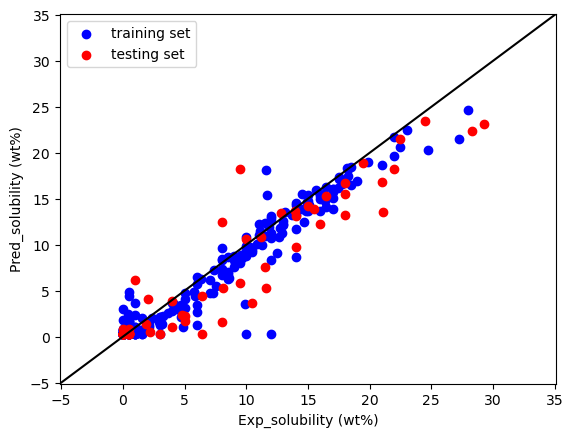

In [17]:
Y_test_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
r2_test = sklearn.metrics.r2_score(Y_test, Y_test_pred)
r2_train = sklearn.metrics.r2_score(Y_train, Y_train_pred)
mse_test = mean_squared_error(Y_test, Y_test_pred)
plt.figure()
plt.xlabel("Exp_solubility (wt%)")
plt.ylabel("Pred_solubility (wt%)")
plt.plot([-5.1, 35.1], [-5.1, 35.1], Color='black')
plt.scatter(Y_train, Y_train_pred, Color='blue', label='training set')
plt.scatter(Y_test, Y_test_pred, Color='red', label='testing set')
plt.xlim([-5.1, 35.1])
plt.ylim([-5.1, 35.1])
plt.legend()
print('R^2_test=%f'%r2_test)
print('mse_test=%f'%mse_test)

Interpret model using SHAP

In [18]:
explainer = shap.Explainer(model.predict, X_train, seed=1)
shap_values = explainer(X_test, max_evals=2000)

759/759 [==============================] - 1s 727us/step


PermutationExplainer explainer:   3%|▎         | 2/76 [00:00<?, ?it/s]

865/865 [==============================] - 1s 752us/step


PermutationExplainer explainer:   5%|▌         | 4/76 [00:15<02:36,  2.17s/it]

887/887 [==============================] - 1s 760us/step


PermutationExplainer explainer:   7%|▋         | 5/76 [00:20<03:50,  3.24s/it]

954/954 [==============================] - 1s 716us/step


PermutationExplainer explainer:   8%|▊         | 6/76 [00:25<04:32,  3.89s/it]

899/899 [==============================] - 1s 720us/step


PermutationExplainer explainer:   9%|▉         | 7/76 [00:29<04:43,  4.11s/it]

717/717 [==============================] - 1s 715us/step


PermutationExplainer explainer:  11%|█         | 8/76 [00:33<04:32,  4.00s/it]

753/753 [==============================] - 1s 735us/step


PermutationExplainer explainer:  12%|█▏        | 9/76 [00:37<04:27,  3.99s/it]

721/721 [==============================] - 1s 723us/step


PermutationExplainer explainer:  13%|█▎        | 10/76 [00:41<04:18,  3.92s/it]

768/768 [==============================] - 1s 684us/step


PermutationExplainer explainer:  14%|█▍        | 11/76 [00:44<04:07,  3.81s/it]

877/877 [==============================] - 1s 718us/step


PermutationExplainer explainer:  16%|█▌        | 12/76 [00:48<04:10,  3.92s/it]

881/881 [==============================] - 1s 687us/step


PermutationExplainer explainer:  17%|█▋        | 13/76 [00:53<04:21,  4.15s/it]

989/989 [==============================] - 1s 706us/step


PermutationExplainer explainer:  18%|█▊        | 14/76 [00:58<04:31,  4.38s/it]

943/943 [==============================] - 1s 745us/step


PermutationExplainer explainer:  20%|█▉        | 15/76 [01:03<04:44,  4.67s/it]

793/793 [==============================] - 1s 718us/step


PermutationExplainer explainer:  21%|██        | 16/76 [01:08<04:31,  4.53s/it]

936/936 [==============================] - 1s 752us/step


PermutationExplainer explainer:  22%|██▏       | 17/76 [01:12<04:33,  4.63s/it]

780/780 [==============================] - 1s 729us/step


PermutationExplainer explainer:  24%|██▎       | 18/76 [01:17<04:19,  4.48s/it]

891/891 [==============================] - 1s 706us/step


PermutationExplainer explainer:  25%|██▌       | 19/76 [01:21<04:15,  4.48s/it]

900/900 [==============================] - 1s 715us/step


PermutationExplainer explainer:  26%|██▋       | 20/76 [01:26<04:14,  4.54s/it]

882/882 [==============================] - 1s 743us/step


PermutationExplainer explainer:  28%|██▊       | 21/76 [01:30<04:09,  4.53s/it]

713/713 [==============================] - 1s 733us/step


PermutationExplainer explainer:  29%|██▉       | 22/76 [01:34<03:49,  4.26s/it]

760/760 [==============================] - 1s 696us/step


PermutationExplainer explainer:  30%|███       | 23/76 [01:38<03:43,  4.22s/it]

934/934 [==============================] - 1s 724us/step


PermutationExplainer explainer:  32%|███▏      | 24/76 [01:43<03:55,  4.52s/it]

790/790 [==============================] - 1s 710us/step


PermutationExplainer explainer:  33%|███▎      | 25/76 [01:47<03:42,  4.36s/it]

1100/1100 [==============================] - 1s 754us/step


PermutationExplainer explainer:  34%|███▍      | 26/76 [01:53<03:59,  4.79s/it]

782/782 [==============================] - 1s 718us/step


PermutationExplainer explainer:  36%|███▌      | 27/76 [01:57<03:45,  4.59s/it]

722/722 [==============================] - 1s 730us/step


PermutationExplainer explainer:  37%|███▋      | 28/76 [02:01<03:28,  4.34s/it]

973/973 [==============================] - 1s 716us/step


PermutationExplainer explainer:  38%|███▊      | 29/76 [02:06<03:34,  4.56s/it]

799/799 [==============================] - 1s 679us/step


PermutationExplainer explainer:  39%|███▉      | 30/76 [02:10<03:24,  4.44s/it]

772/772 [==============================] - 1s 717us/step


PermutationExplainer explainer:  41%|████      | 31/76 [02:14<03:12,  4.27s/it]

724/724 [==============================] - 1s 732us/step


PermutationExplainer explainer:  42%|████▏     | 32/76 [02:18<03:02,  4.14s/it]

952/952 [==============================] - 1s 765us/step


PermutationExplainer explainer:  43%|████▎     | 33/76 [02:23<03:10,  4.42s/it]

1002/1002 [==============================] - 1s 751us/step


PermutationExplainer explainer:  45%|████▍     | 34/76 [02:28<03:15,  4.65s/it]

775/775 [==============================] - 1s 751us/step


PermutationExplainer explainer:  46%|████▌     | 35/76 [02:33<03:09,  4.63s/it]

776/776 [==============================] - 1s 747us/step


PermutationExplainer explainer:  47%|████▋     | 36/76 [02:37<02:57,  4.45s/it]

867/867 [==============================] - 1s 693us/step


PermutationExplainer explainer:  49%|████▊     | 37/76 [02:41<02:53,  4.44s/it]

697/697 [==============================] - 1s 734us/step


PermutationExplainer explainer:  50%|█████     | 38/76 [02:45<02:41,  4.25s/it]

912/912 [==============================] - 1s 749us/step


PermutationExplainer explainer:  51%|█████▏    | 39/76 [02:50<02:42,  4.38s/it]

1021/1021 [==============================] - 1s 716us/step


PermutationExplainer explainer:  53%|█████▎    | 40/76 [02:55<02:49,  4.71s/it]

1009/1009 [==============================] - 1s 738us/step


PermutationExplainer explainer:  54%|█████▍    | 41/76 [03:00<02:51,  4.89s/it]

795/795 [==============================] - 1s 734us/step


PermutationExplainer explainer:  55%|█████▌    | 42/76 [03:05<02:38,  4.67s/it]

1051/1051 [==============================] - 1s 757us/step


PermutationExplainer explainer:  57%|█████▋    | 43/76 [03:10<02:45,  5.01s/it]

786/786 [==============================] - 1s 739us/step


PermutationExplainer explainer:  58%|█████▊    | 44/76 [03:15<02:33,  4.79s/it]

766/766 [==============================] - 1s 695us/step


PermutationExplainer explainer:  59%|█████▉    | 45/76 [03:19<02:20,  4.53s/it]

879/879 [==============================] - 1s 751us/step


PermutationExplainer explainer:  61%|██████    | 46/76 [03:23<02:16,  4.55s/it]

801/801 [==============================] - 1s 728us/step


PermutationExplainer explainer:  62%|██████▏   | 47/76 [03:27<02:08,  4.44s/it]

766/766 [==============================] - 1s 721us/step


PermutationExplainer explainer:  63%|██████▎   | 48/76 [03:31<01:58,  4.22s/it]

848/848 [==============================] - 1s 709us/step


PermutationExplainer explainer:  64%|██████▍   | 49/76 [03:35<01:54,  4.25s/it]

832/832 [==============================] - 1s 681us/step


PermutationExplainer explainer:  66%|██████▌   | 50/76 [03:40<01:51,  4.31s/it]

1055/1055 [==============================] - 1s 700us/step


PermutationExplainer explainer:  67%|██████▋   | 51/76 [03:45<01:55,  4.60s/it]

1065/1065 [==============================] - 1s 734us/step


PermutationExplainer explainer:  68%|██████▊   | 52/76 [03:51<01:57,  4.88s/it]

786/786 [==============================] - 1s 686us/step


PermutationExplainer explainer:  70%|██████▉   | 53/76 [03:54<01:44,  4.55s/it]

699/699 [==============================] - 1s 711us/step


PermutationExplainer explainer:  71%|███████   | 54/76 [03:58<01:33,  4.24s/it]

789/789 [==============================] - 1s 759us/step


PermutationExplainer explainer:  72%|███████▏  | 55/76 [04:03<01:32,  4.41s/it]

809/809 [==============================] - 1s 756us/step


PermutationExplainer explainer:  74%|███████▎  | 56/76 [04:07<01:29,  4.46s/it]

929/929 [==============================] - 1s 721us/step


PermutationExplainer explainer:  75%|███████▌  | 57/76 [04:12<01:27,  4.59s/it]

709/709 [==============================] - 1s 726us/step


PermutationExplainer explainer:  76%|███████▋  | 58/76 [04:16<01:18,  4.34s/it]

897/897 [==============================] - 1s 709us/step


PermutationExplainer explainer:  78%|███████▊  | 59/76 [04:20<01:13,  4.35s/it]

753/753 [==============================] - 1s 693us/step


PermutationExplainer explainer:  79%|███████▉  | 60/76 [04:24<01:08,  4.25s/it]

1006/1006 [==============================] - 1s 684us/step


PermutationExplainer explainer:  80%|████████  | 61/76 [04:29<01:07,  4.52s/it]

1029/1029 [==============================] - 1s 728us/step


PermutationExplainer explainer:  82%|████████▏ | 62/76 [04:35<01:07,  4.84s/it]

805/805 [==============================] - 1s 706us/step


PermutationExplainer explainer:  83%|████████▎ | 63/76 [04:39<00:58,  4.54s/it]

966/966 [==============================] - 1s 701us/step


PermutationExplainer explainer:  84%|████████▍ | 64/76 [04:44<00:56,  4.67s/it]

834/834 [==============================] - 1s 703us/step


PermutationExplainer explainer:  86%|████████▌ | 65/76 [04:48<00:49,  4.54s/it]

818/818 [==============================] - 1s 721us/step


PermutationExplainer explainer:  87%|████████▋ | 66/76 [04:52<00:43,  4.37s/it]

814/814 [==============================] - 1s 722us/step


PermutationExplainer explainer:  88%|████████▊ | 67/76 [04:56<00:39,  4.34s/it]

772/772 [==============================] - 1s 690us/step


PermutationExplainer explainer:  89%|████████▉ | 68/76 [05:00<00:33,  4.19s/it]

1032/1032 [==============================] - 1s 756us/step


PermutationExplainer explainer:  91%|█████████ | 69/76 [05:06<00:31,  4.54s/it]

817/817 [==============================] - 1s 697us/step


PermutationExplainer explainer:  92%|█████████▏| 70/76 [05:10<00:26,  4.48s/it]

770/770 [==============================] - 1s 733us/step


PermutationExplainer explainer:  93%|█████████▎| 71/76 [05:14<00:21,  4.33s/it]

913/913 [==============================] - 1s 714us/step


PermutationExplainer explainer:  95%|█████████▍| 72/76 [05:19<00:18,  4.55s/it]

714/714 [==============================] - 1s 703us/step


PermutationExplainer explainer:  96%|█████████▌| 73/76 [05:22<00:12,  4.26s/it]

789/789 [==============================] - 1s 720us/step


PermutationExplainer explainer:  97%|█████████▋| 74/76 [05:26<00:08,  4.16s/it]

836/836 [==============================] - 1s 692us/step


PermutationExplainer explainer:  99%|█████████▊| 75/76 [05:31<00:04,  4.31s/it]

704/704 [==============================] - 1s 718us/step


PermutationExplainer explainer: 100%|██████████| 76/76 [05:35<00:00,  4.14s/it]

881/881 [==============================] - 1s 684us/step


PermutationExplainer explainer: 77it [05:39,  4.53s/it]                        


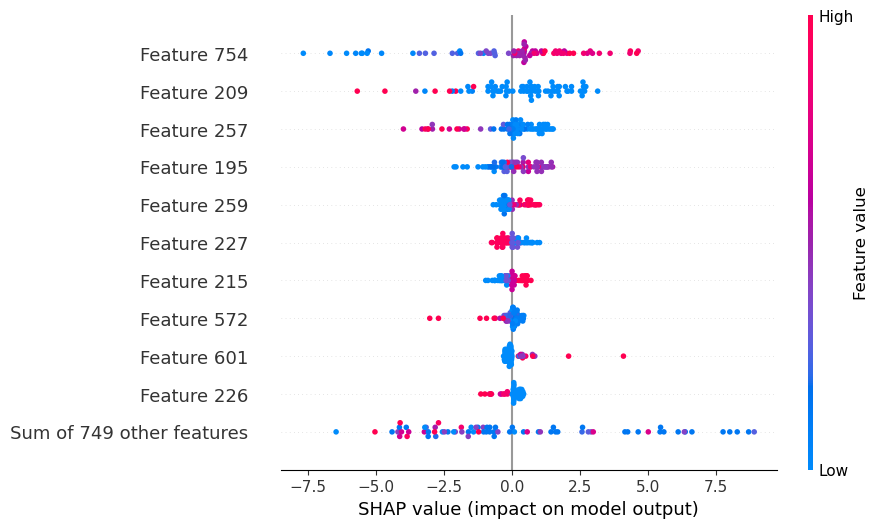

In [19]:
shap.plots.beeswarm(shap_values, max_display=11)

## Cross validation

1. Random forest (RF) regression

In [20]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y))
for train_index, test_index in kf.split(X, Y):
    regr = RandomForestRegressor(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the

R2:  0.7983064884290731
MSE:  10.126559053914386


2. Extreme gradient boosting (XGBoost) regression

In [21]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y))
for train_index, test_index in kf.split(X, Y):
    regr = GradientBoostingRegressor(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
A column-vector y was passed when a 1d array was expected. Please cha

R2:  0.785864954822599
MSE:  10.751219330816332


3. Ridge regression

In [22]:
kf = KFold(n_splits=10)
pred = np.zeros(len(Y)).reshape(-1, 1)
for train_index, test_index in kf.split(X, Y):
    regr = Ridge(random_state=1)
    regr.fit(X[train_index], Y[train_index])
    pred[test_index] = regr.predict(X[test_index])

print("R2: ", r2_score(Y, pred))
print("MSE: ", mean_squared_error(Y, pred))

R2:  0.6059780243267192
MSE:  19.782920997894152


4. Artificial neural network (ANN) models

Please run python script: cross_validation_for_ANN_model.py
```bash
python cross_validation_for_ANN_model.py
```

## Applicability  domain

In [23]:
def identify_domian(training_set, test_IL):
    """
    A function to identifiy whether a test ionic liquid of interest located in the applicabilty domain of the training set.
    training_set: the descriptors numpy array of training set
    test_IL: the descriptors numpy array of IL to be tested
    """
    X_average = np.mean(training_set, axis=0)
    segma = np.std(training_set, axis=0)
    for i in range(len(segma)):
        if segma[i] == 0:
            segma[i] = 1
    S_k = np.abs(test_IL - X_average) / segma 
    if S_k.max() <= 3:
        ans = S_k.max()
    if S_k.min() > 3:
        ans = S_k.min()
    if S_k.max() > 3 and S_k.min() <= 3:
        ans = S_k.mean() + 1.28 * S_k.std()
    return ans